## Preprocess

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import optuna
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import Ridge, LinearRegression

In [2]:
df=pd.read_csv("Train.csv")
df

,rating,title,text,asin,parent_asin,timestamp,helpful_vote,verified_purchase
0,5,Unique and authentic,A very classy and chic look. This necklace is ...,B0107QYW14,B0107QYW14,1.460000e+12,2,True
1,2,Uncomfortable,The cloth bands tend to scrunch up under my wi...,B08WX159BW,B08WX159BW,1.630000e+12,0,True
2,3,Something has changed for the worse,Really loved this product the first time I bou...,B083F76L79,B083F76L79,1.630000e+12,1,True
3,5,Five Stars,beautiful,B00FBXJ11K,B00FBXJ11K,1.440000e+12,0,True
4,3,1/4 and 3/4,I was so excited to get these. I opened the b...,B00F029PWC,B00F029PWC,1.520000e+12,0,True
...,...,...,...,...,...,...,...,...
39981,5,Welcome relief,I have used DMSO for sometime and it works ver...,B0070Z7KME,B00J7QCNDU,1.420000e+12,0,True
39982,3,Not sure yet.........,It holds basic hairstyles...but I am not in lo...,B01HCWXUIC,B01HCWXUIC,1.470000e+12,0,True
39983,5,*****5-STARS PLUS*****,Even though we all want to see immediate resul...,B01CYTUXHO,B01CYTUXHO,1.490000e+12,0,False
39984,5,A fine shaver,Works very well and gives a nice shave.,B07K1DRCYR,B07K1DRCYR,1.560000e+12,0,True


In [3]:
print(df.isnull().sum().sum())  

0


In [4]:
df["comment"]=df["title"]+" , "+df["text"]
df

,rating,title,text,asin,parent_asin,timestamp,helpful_vote,verified_purchase,comment
0,5,Unique and authentic,A very classy and chic look. This necklace is ...,B0107QYW14,B0107QYW14,1.460000e+12,2,True,"Unique and authentic , A very classy and chic ..."
1,2,Uncomfortable,The cloth bands tend to scrunch up under my wi...,B08WX159BW,B08WX159BW,1.630000e+12,0,True,"Uncomfortable , The cloth bands tend to scrunc..."
2,3,Something has changed for the worse,Really loved this product the first time I bou...,B083F76L79,B083F76L79,1.630000e+12,1,True,"Something has changed for the worse , Really l..."
3,5,Five Stars,beautiful,B00FBXJ11K,B00FBXJ11K,1.440000e+12,0,True,"Five Stars , beautiful"
4,3,1/4 and 3/4,I was so excited to get these. I opened the b...,B00F029PWC,B00F029PWC,1.520000e+12,0,True,"1/4 and 3/4 , I was so excited to get these. ..."
...,...,...,...,...,...,...,...,...,...
39981,5,Welcome relief,I have used DMSO for sometime and it works ver...,B0070Z7KME,B00J7QCNDU,1.420000e+12,0,True,"Welcome relief , I have used DMSO for sometime..."
39982,3,Not sure yet.........,It holds basic hairstyles...but I am not in lo...,B01HCWXUIC,B01HCWXUIC,1.470000e+12,0,True,"Not sure yet......... , It holds basic hairsty..."
39983,5,*****5-STARS PLUS*****,Even though we all want to see immediate resul...,B01CYTUXHO,B01CYTUXHO,1.490000e+12,0,False,"*****5-STARS PLUS***** , Even though we all wa..."
39984,5,A fine shaver,Works very well and gives a nice shave.,B07K1DRCYR,B07K1DRCYR,1.560000e+12,0,True,"A fine shaver , Works very well and gives a ni..."


In [5]:
sw_list = stopwords.words('english')
sw_list.remove("not")
sw_list.remove("very")

In [6]:
nlp = spacy.load("en_core_web_sm")

In [7]:
##checking stuff
digit_mapping = {
    "0": "zero", "1": "one", "2": "two", "3": "three", "4": "four",
    "5": "five", "6": "six", "7": "seven", "8": "eight", "9": "nine"
}

def replace_digits(text):
    return "".join(digit_mapping.get(char, char) for char in text)

def remunique(x):
    x = replace_digits(x)  
    return "".join([i if i.isalnum() or i == " " else " " for i in x])

def preprocess_text(text):
    doc = nlp(text)
    filtered_tokens = [token.lemma_ for token in doc if token.lemma_ not in sw_list and token.pos_ in {"ADJ", "NOUN", "VERB", "ADV", "NUM"}]
    return " ".join(filtered_tokens)

# Processing the string
doc = "*****Five Stars , 2 beautiful****"
doc = remunique(doc)  
doc = doc.lower() 
doc = preprocess_text(doc)

print(doc)


five star two beautiful


In [8]:
digit_mapping = {
    "0": "zero", "1": "one", "2": "two", "3": "three", "4": "four",
    "5": "five", "6": "six", "7": "seven", "8": "eight", "9": "nine"
}

def replace_digits(text):
    return "".join(digit_mapping.get(char, char) for char in text)

def remunique(x):
    x = replace_digits(x)  
    return "".join([i.lower() if i.isalnum() or i == " " else " " for i in x])

def preprocess_text(text):
    doc = nlp(text)
    filtered_tokens = [token.lemma_ for token in doc if token.lemma_ not in sw_list and token.pos_ in {"ADJ", "NOUN", "VERB", "ADV", "NUM"}]
    return " ".join(filtered_tokens)

df["comment"] = df["comment"].apply(remunique)
df["comment"] = df["comment"].apply(preprocess_text)

df["comment"]

0        unique authentic very classy chic look necklac...
1        uncomfortable cloth band tend scrunch wig thin...
2        change bad really love product first time buy ...
3                                      five star beautiful
4        one four three four excited get open bag count...
                               ...                        
39981    welcome relief use dmso sometime work very wel...
39982    sure yet hold basic hairstyle love product use...
39983    five star even want see immediate result growt...
39984           fine shaver work very well give nice shave
39985    work first time buy work also small hair packa...
Name: comment, Length: 39986, dtype: object

In [9]:
sia = SentimentIntensityAnalyzer()

In [10]:
df['text_compound'] = df['text'].apply(
        lambda x: sia.polarity_scores(str(x))['compound'] if isinstance(x, str) else 0)
df['text_pos'] = df['text'].apply(
        lambda x: sia.polarity_scores(str(x))['pos'] if isinstance(x, str) else 0)
df['text_neg'] = df['text'].apply(
        lambda x: sia.polarity_scores(str(x))['neg'] if isinstance(x, str) else 0)
df["purchase"]=df["verified_purchase"].apply(lambda x: 1 if x=="True" else 0)

In [11]:
df

,rating,title,text,asin,parent_asin,timestamp,helpful_vote,verified_purchase,comment,text_compound,text_pos,text_neg,purchase
0,5,Unique and authentic,A very classy and chic look. This necklace is ...,B0107QYW14,B0107QYW14,1.460000e+12,2,True,unique authentic very classy chic look necklac...,0.9013,0.232,0.036,0
1,2,Uncomfortable,The cloth bands tend to scrunch up under my wi...,B08WX159BW,B08WX159BW,1.630000e+12,0,True,uncomfortable cloth band tend scrunch wig thin...,0.2492,0.067,0.025,0
2,3,Something has changed for the worse,Really loved this product the first time I bou...,B083F76L79,B083F76L79,1.630000e+12,1,True,change bad really love product first time buy ...,-0.0781,0.075,0.064,0
3,5,Five Stars,beautiful,B00FBXJ11K,B00FBXJ11K,1.440000e+12,0,True,five star beautiful,0.5994,1.000,0.000,0
4,3,1/4 and 3/4,I was so excited to get these. I opened the b...,B00F029PWC,B00F029PWC,1.520000e+12,0,True,one four three four excited get open bag count...,0.9848,0.214,0.027,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39981,5,Welcome relief,I have used DMSO for sometime and it works ver...,B0070Z7KME,B00J7QCNDU,1.420000e+12,0,True,welcome relief use dmso sometime work very wel...,0.2944,0.149,0.090,0
39982,3,Not sure yet.........,It holds basic hairstyles...but I am not in lo...,B01HCWXUIC,B01HCWXUIC,1.470000e+12,0,True,sure yet hold basic hairstyle love product use...,-0.2670,0.087,0.108,0
39983,5,*****5-STARS PLUS*****,Even though we all want to see immediate resul...,B01CYTUXHO,B01CYTUXHO,1.490000e+12,0,False,five star even want see immediate result growt...,0.6638,0.115,0.061,0
39984,5,A fine shaver,Works very well and gives a nice shave.,B07K1DRCYR,B07K1DRCYR,1.560000e+12,0,True,fine shaver work very well give nice shave,0.6361,0.509,0.000,0


In [12]:
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms', errors='coerce')
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day_of_week'] = df['datetime'].dt.dayofweek
df['hour'] = df['datetime'].dt.hour

In [13]:
train_features=df[["comment","text_compound","text_pos","text_neg","year","month","hour","day_of_week","verified_purchase","helpful_vote"]]
scaler = StandardScaler()

In [14]:
X=train_features
y=df["rating"]

## vectorization+model making

## as regression

In [ ]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# TF-IDF transformation
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train["comment"]).toarray()
X_test_tfidf = tfidf.transform(X_test["comment"]).toarray()

train_features_scaled = scaler.fit_transform(X_train[["text_compound","text_pos","text_neg","year","month","hour","day_of_week","verified_purchase","helpful_vote"]])
test_features_scaled = scaler.transform(X_test[["text_compound","text_pos","text_neg","year","month","hour","day_of_week","verified_purchase","helpful_vote"]])

X_trainf = np.hstack((X_train_tfidf, train_features_scaled))
X_testf = np.hstack((X_test_tfidf, test_features_scaled))

models = {
    'lightgbm': lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.08,
        num_leaves=31,
        colsample_bytree=0.8,
        subsample=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        min_child_samples=20,
        objective='regression',
        random_state=42
    ),
    'xgboost': xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.08,
        max_depth=7,
        colsample_bytree=0.8,
        subsample=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        min_child_weight=1,
        objective='reg:squarederror',
        random_state=42
    ),
    'catboost': CatBoostRegressor(
        iterations=1000,
        learning_rate=0.08,
        depth=6,
        loss_function='RMSE',
        random_seed=42,
        verbose=0
    ),
    'ridge': Ridge(
        alpha=1.0,
        random_state=42
    )
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_trainf, y_train)
    val_pred = model.predict(X_testf)
    val_rmse = np.sqrt(mean_squared_error(y_test, val_pred))
    print(f"{name} validation RMSE: {val_rmse:.4f}")
    results[name] = {'model': model, 'rmse': val_rmse}

# Create an ensemble model using the best-performing models
best_models = [(name, model['model']) for name, model in sorted(results.items(), key=lambda x: x[1]['rmse'])[:3]]
ensemble = VotingRegressor(estimators=best_models)
ensemble.fit(X_trainf, y_train)

# Evaluate ensemble
ensemble_val_pred = ensemble.predict(X_testf)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_val_pred))
print(f"Ensemble validation RMSE: {ensemble_rmse:.4f}")

#regression works better and faster

## As Classifier

In [ ]:
# from sklearn.ensemble import VotingClassifier
# from sklearn.metrics import accuracy_score, classification_report
# import lightgbm as lgb
# import xgboost as xgb
# from catboost import CatBoostClassifier
# from sklearn.linear_model import RidgeClassifier

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# y_train_adj = y_train - 1
# y_test_adj = y_test - 1

# tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
# X_train_tfidf = tfidf.fit_transform(X_train["comment"]).toarray()
# X_test_tfidf = tfidf.transform(X_test["comment"]).toarray()

# scaler = StandardScaler()
# train_features_scaled = scaler.fit_transform(X_train[["text_compound", "text_pos", "text_neg", "year", "month", "hour", "day_of_week", "verified_purchase", "helpful_vote"]])
# test_features_scaled = scaler.transform(X_test[["text_compound", "text_pos", "text_neg", "year", "month", "hour", "day_of_week", "verified_purchase", "helpful_vote"]])

# X_trainf = np.hstack((X_train_tfidf, train_features_scaled))
# X_testf = np.hstack((X_test_tfidf, test_features_scaled))

# models = {
#     'lightgbm': lgb.LGBMClassifier(
#         n_estimators=300,
#         learning_rate=0.08,
#         num_leaves=31,
#         colsample_bytree=0.8,
#         subsample=0.8,
#         reg_alpha=0.1,
#         reg_lambda=0.1,
#         min_child_samples=20,
#         objective='multiclass',
#         random_state=42
#     ),
#     'xgboost': xgb.XGBClassifier(
#         n_estimators=300,
#         learning_rate=0.08,
#         max_depth=7,
#         colsample_bytree=0.8,
#         subsample=0.8,
#         reg_alpha=0.1,
#         reg_lambda=0.1,
#         min_child_weight=1,
#         objective='multi:softmax',
#         num_class=5,  # Set to 5 for XGBoost
#         random_state=42
#     ),
#     'catboost': CatBoostClassifier(
#         iterations=300,
#         learning_rate=0.08,
#         depth=6,
#         loss_function='MultiClass',
#         random_seed=42,
#         verbose=0
#     ),
#     'ridge': RidgeClassifier(alpha=1.0)
# }

# results = {}
# for name, model in models.items():
#     print(f"Training {name}...")
#     model.fit(X_trainf, y_train_adj)  # Train on adjusted labels (0-4)
#     val_pred = model.predict(X_testf) + 1  # Convert predictions back to 1-5
#     val_acc = accuracy_score(y_test, val_pred)
#     print(f"{name} validation accuracy: {val_acc:.4f}")
#     results[name] = {'model': model, 'accuracy': val_acc}

# best_models = [(name, model['model']) for name, model in sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)[:3]]

# ensemble = VotingClassifier(estimators=best_models, voting='hard')
# ensemble.fit(X_trainf, y_train_adj) 

# ensemble_val_pred = ensemble.predict(X_testf) + 1
# ensemble_acc = accuracy_score(y_test, ensemble_val_pred)
# print(f"Ensemble validation accuracy: {ensemble_acc:.4f}")

# print(classification_report(y_test, ensemble_val_pred))


Training lightgbm...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 172270
[LightGBM] [Info] Number of data points in the train set: 31988, number of used features: 4912
[LightGBM] [Info] Start training from score -2.220054
[LightGBM] [Info] Start training from score -2.803188
[LightGBM] [Info] Start training from score -2.392408
[LightGBM] [Info] Start training from score -1.983529
[LightGBM] [Info] Start training from score -0.507850


e:\python\Kaggle_Hack\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


lightgbm validation accuracy: 0.7261
Training xgboost...
xgboost validation accuracy: 0.7261
Training catboost...
catboost validation accuracy: 0.7171
Training ridge...
ridge validation accuracy: 0.7234
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.235331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172270
[LightGBM] [Info] Number of data points in the train set: 31988, number of used features: 4912
[LightGBM] [Info] Start training from score -2.220054
[LightGBM] [Info] Start training from score -2.803188
[LightGBM] [Info] Start training from score -2.392408
[LightGBM] [Info] Start training from score -1.983529
[LightGBM] [Info] Start training from score -0.507850


e:\python\Kaggle_Hack\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Ensemble validation accuracy: 0.7291
              precision    recall  f1-score   support

           1       0.59      0.70      0.64       823
           2       0.48      0.17      0.25       468
           3       0.53      0.28      0.37       754
           4       0.58      0.28      0.37      1098
           5       0.79      0.96      0.86      4855

    accuracy                           0.73      7998
   macro avg       0.59      0.48      0.50      7998
weighted avg       0.70      0.73      0.69      7998



## Prediction

In [41]:
tf=pd.read_csv("Test.csv")
tf

,title,text,asin,parent_asin,timestamp,helpful_vote,verified_purchase,rating
0,just a brush,I didn't realize I was buying just a brush. I...,B07S29RTQZ,B07S29RTQZ,1.610000e+12,0,True,NaN
1,Easy fast and convenient to stay clean,Great for your purse and camping! When the ki...,B07PWLXFR5,B07PWLXFR5,1.600000e+12,0,True,NaN
2,AVOID! Simply thicker personal wipes.,"I expected a larger ""towel."" Disappointed. Th...",B01LXQTVNE,B01LXQTVNE,1.620000e+12,1,True,NaN
3,Five Stars,Great product!,B00N11BR2A,B00N11BR2A,1.520000e+12,2,True,NaN
4,It looks like the picture.,"I don't love it. But, I can and will wear it....",B08D7Q5J6Y,B08D7Q5J6Y,1.630000e+12,0,True,NaN
...,...,...,...,...,...,...,...,...
195,Five Stars,cool,B00BSXEUOA,B00BSXEUOA,1.460000e+12,0,True,NaN
196,Not recommended.,Works ok. keeps collapsing. The nubs on the ma...,B019GBG0IE,B019GBG0IE,1.530000e+12,0,True,NaN
197,Great Products,Every shampoo I use breaks my scalp out. Disc...,B07BR5QSTK,B07BR5QSTK,1.630000e+12,0,True,NaN
198,"Kinda works, but not where I need it.",The product helps to keep my hands a little dr...,B001O1M6II,B001O1M6II,1.440000e+12,3,True,NaN


In [42]:
tf["comment"]=tf["title"]+" , "+tf["text"]

In [43]:
tf["comment"] = tf["comment"].apply(remunique)
tf["comment"] = tf["comment"].apply(preprocess_text)
tf["purchase"]=tf["verified_purchase"].apply(lambda x: 1 if x=="True" else 0)
tf["comment"]

0      brush realize buy brush mean get brush dryer b...
1      easy fast convenient stay clean great purse ca...
2      avoid simply thick personal wipe expect large ...
3                                five star great product
4      look picture love wear well buying wig online ...
                             ...                        
195                                       five star cool
196    recommend work ok keep collapse nub main part ...
197    great product shampoo use break scalp discover...
198    kinda work need product help keep hand little ...
199    love try find everywhere use create bubble fac...
Name: comment, Length: 200, dtype: object

In [44]:
tf['text_compound'] = tf['text'].apply(
        lambda x: sia.polarity_scores(str(x))['compound'] if isinstance(x, str) else 0)
tf['text_pos'] = tf['text'].apply(
        lambda x: sia.polarity_scores(str(x))['pos'] if isinstance(x, str) else 0)
tf['text_neg'] = tf['text'].apply(
        lambda x: sia.polarity_scores(str(x))['neg'] if isinstance(x, str) else 0)

In [45]:
tf['datetime'] = pd.to_datetime(tf['timestamp'], unit='ms', errors='coerce')
tf['year'] = tf['datetime'].dt.year
tf['month'] = tf['datetime'].dt.month
tf['day_of_week'] = tf['datetime'].dt.dayofweek
tf['hour'] = tf['datetime'].dt.hour

In [ ]:
test_features=tf[["text_compound","text_pos","text_neg","year","month","hour","day_of_week","verified_purchase","helpful_vote"]]
tff = scaler.transform(test_features)
X_test_tfidf = tfidf.transform(tf["comment"]).toarray() 
X_test = np.hstack((X_test_tfidf, tff))
y_pred=ensemble.predict(X_test)

e:\python\Kaggle_Hack\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [47]:
X_test[0]

array([ 0.        ,  0.        ,  0.        , ...,  0.00958679,
        0.40821107, -0.2214812 ])

In [48]:
# def adjust_predictions(preds):
#     adjusted = np.round(preds * 2) / 2
#     adjusted = np.where(
#         (adjusted >= 4.5) & (adjusted < 5), 
#         5.0, 
#         adjusted
#     )
    
#     adjusted = np.where(
#         (adjusted > 1) & (adjusted <= 1.5), 
#         1.0, 
#         adjusted
#     )
    
#     return adjusted

In [49]:
# y_pred1=adjust_predictions(y_pred)

In [50]:
A=[]
for i in y_pred:
    if i>5:
        A.append(5)
    elif i<1:
        A.append(1)
    else: A.append(round(i))
A

[1,
 5,
 2,
 5,
 5,
 5,
 5,
 3,
 5,
 4,
 5,
 4,
 5,
 5,
 3,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 1,
 5,
 5,
 5,
 5,
 5,
 1,
 5,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 3,
 1,
 5,
 5,
 5,
 5,
 5,
 4,
 5,
 5,
 5,
 5,
 5,
 1,
 4,
 5,
 5,
 5,
 5,
 5,
 1,
 4,
 5,
 5,
 5,
 5,
 1,
 4,
 5,
 5,
 1,
 5,
 3,
 1,
 5,
 1,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 3,
 1,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 1,
 5,
 5,
 5,
 5,
 1,
 5,
 1,
 5,
 5,
 5,
 5,
 3,
 4,
 5,
 3,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 1,
 5,
 4,
 4,
 5,
 5,
 4,
 5,
 5,
 5,
 5,
 5,
 1,
 5,
 2,
 5,
 5,
 5,
 1,
 5,
 5,
 1,
 5,
 4,
 5,
 5,
 1,
 1,
 5,
 5,
 5,
 5,
 5,
 2,
 5,
 4,
 3,
 3,
 5,
 5,
 5,
 4,
 5,
 4,
 5,
 5,
 5,
 1,
 1,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 3,
 5,
 3,
 5,
 5,
 1,
 5,
 5,
 3,
 5,
 3,
 5]

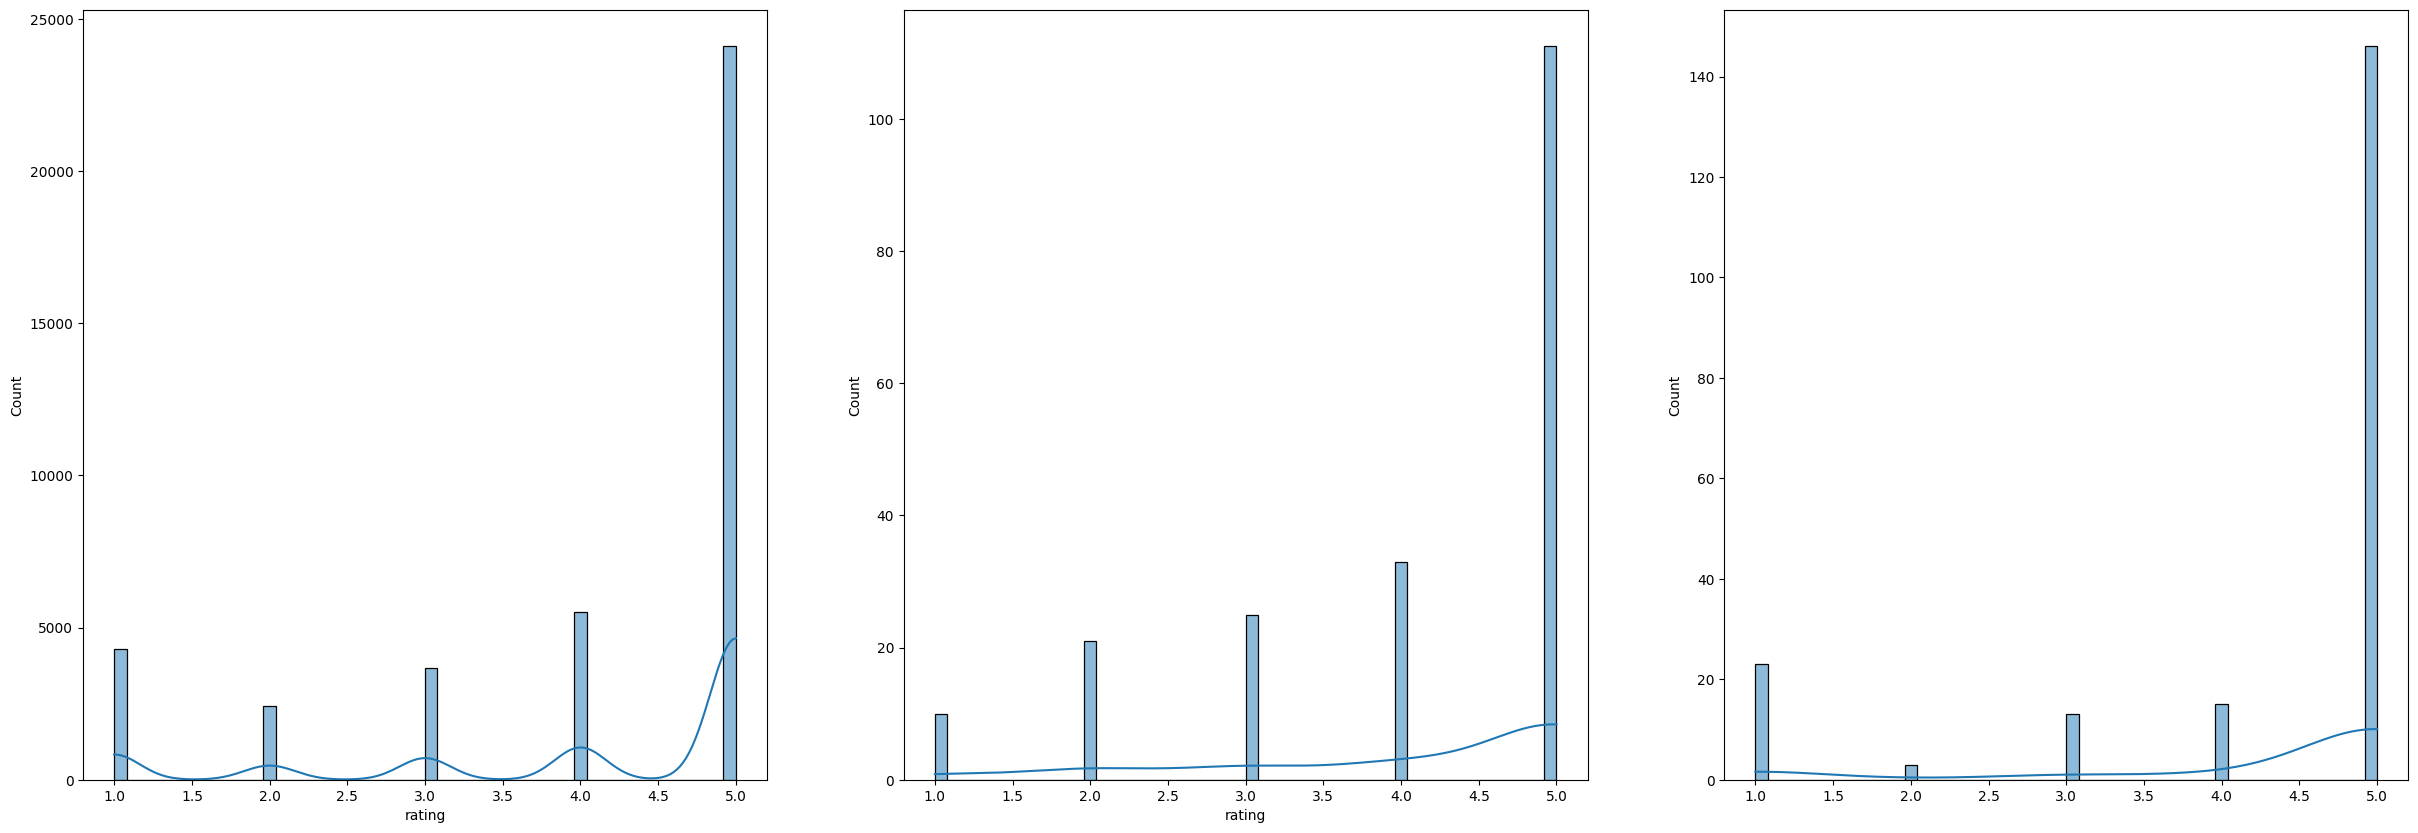

In [51]:
plt.figure(figsize=(30,10))

plt.subplot(131)
df1=pd.read_csv("Train.csv")
sns.histplot(df1["rating"], kde=True, bins=50)

plt.subplot(132)
df2=pd.read_csv("predictions9.csv")
sns.histplot(df2["rating"], kde=True, bins=50)

plt.subplot(133)
sns.histplot(A, kde=True, bins=50)
plt.show()

In [52]:
prediction=pd.DataFrame()
prediction["rating"]=A
prediction.to_csv("predictions1.csv", index=False)